In [20]:
# Read NetworkX package
# https://networkx.org/documentation/stable/index.html
import networkx as nx
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_comm
import seaborn as sns

colors={
    'b':'#4285F4',
    'r':'#DB4437',
    'y':'#F4B400',
    'g':'#0F9D58',
    'gray':'#D3D3D3',
    'purple':'#550a8a'
}

In [11]:
df_policy_has_pa_scholarly=pd.read_pickle('./sample_dta/df_policy_has_pa_scholarly_sample.pkl.bz2')

# Network Construction

In [12]:
# Create bipartite graph.
# https://networkx.org/documentation/stable/reference/algorithms/bipartite.html
# https://en.wikipedia.org/wiki/Bipartite_graph
g_policy_scholarly=nx.Graph() # Define graph
g_policy_scholarly.add_nodes_from(df_policy_has_pa_scholarly.policy_document_id, bipartite='policy_document_id') # Add first set of nodes and label.
g_policy_scholarly.add_nodes_from(df_policy_has_pa_scholarly.scholarly_doi, bipartite='scholarly_doi') # Add second set of nodes and label.
g_policy_scholarly.add_edges_from(df_policy_has_pa_scholarly[['policy_document_id','scholarly_doi']].values) # Add edges

In [13]:
# Project to only article network, i.e., co-occurrence/co-citation network. 
# https://en.wikipedia.org/wiki/Co-occurrence_network
# https://en.wikipedia.org/wiki/Co-citation
g_scholarly=nx.projected_graph(g_policy_scholarly, df_policy_has_pa_scholarly.scholarly_doi)

In [14]:
# The network contains too many nodes for analysis. 
len(g_scholarly)

15746

#   Network Pruning and Visualization

In [15]:
# Network pruning using k-core. Let's try different Ks.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.k_core.html
# Another approach commonly employed is removing isolated nodes.

node_comm_nums=[]
for k in tqdm(range(0, 20, 1)):
    g_scholarly_k=nx.k_core(g_scholarly, k=k)
    lv_comm_tmp=nx_comm.louvain_communities(g_scholarly_k, weight='weight', resolution=1, threshold=1e-07, seed=512)
    node_comm_nums+=[[k, len(g_scholarly_k), len(lv_comm_tmp)]]

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
df_k_test=pd.DataFrame(node_comm_nums).rename(columns={0:'k', 1:'#Article', 2:'#Cluster'})
df_k_test

,k,#Article,#Cluster
0,0,15746,6574
1,1,10135,963
2,2,7371,271
3,3,5636,112
4,4,4513,77
5,5,3678,66
6,6,3117,56
7,7,2705,45
8,8,2330,43
9,9,1975,39


/tmp/ipykernel_895852/3015408536.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ylabels = ['{:,.1f}'.format(x) + 'K' for x in (ax2.get_yticks()/1000)]; ax2.set_yticklabels(ylabels)


Text(0.5, 0, '$k\\_core$')

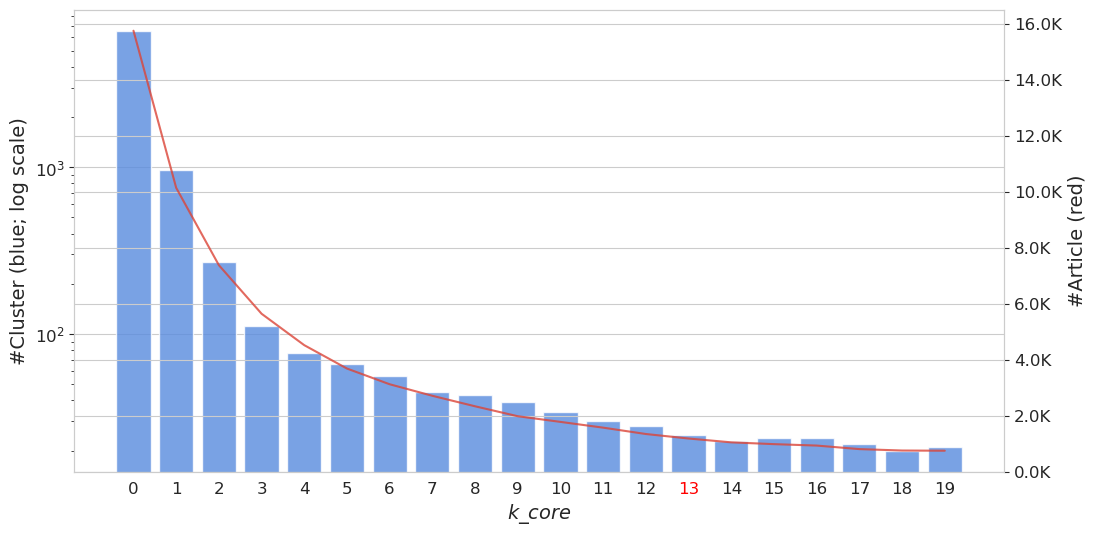

In [22]:
from matplotlib.ticker import MaxNLocator

sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(x=df_k_test.k, y=df_k_test['#Cluster'], color=colors['b'], ax=ax1, alpha=.8)
plt.xticks(fontsize=12); plt.yticks(fontsize=12); ax1.set_ylabel(ylabel='#Cluster (blue; log scale)', fontsize=14)
ax1.set_yscale('log')
ax2=ax1.twinx()

sns.lineplot(x=df_k_test.k, y=df_k_test['#Article'], color=colors['r'], ax=ax2, alpha=.8)
plt.xticks(fontsize=12); plt.yticks(fontsize=12); ax2.set_ylabel(ylabel='#Article (red)', fontsize=14)

# More formatting.
ylabels = ['{:,.1f}'.format(x) + 'K' for x in (ax2.get_yticks()/1000)]; ax2.set_yticklabels(ylabels)
ax1.get_xticklabels()[13].set_color("red")
ax1.set_xlabel(xlabel='$k\_core$', fontsize=14)

In [23]:
g_scholarly_k=nx.k_core(g_scholarly, k=13)

# Export to files
# Analyze in Gephi: https://gephi.org/
nx.write_graphml(g_scholarly_k, './g_scholarly_k.graphml')
nx.write_graphml(g_scholarly, './g_scholarly.graphml')

# Network Analysis and Visualization

In [25]:
len(g_scholarly_k)

1179

In [26]:
lv_communities=nx_comm.louvain_communities(g_scholarly, weight='weight', resolution=1, threshold=1e-07, seed=512)
lv_communities_k=nx_comm.louvain_communities(g_scholarly_k, weight='weight', resolution=1, threshold=1e-07, seed=512)
len(lv_communities), len(lv_communities_k)

(6574, 25)

In [27]:
# Network measures
deg_dict=nx.degree(g_scholarly_k)
deg_cent_dict=nx.degree_centrality(g_scholarly_k)
btw_cent_dict=nx.betweenness_centrality(g_scholarly_k, k=None, normalized=True, weight='weight', endpoints=False, seed=512)

In [28]:
# Nonnetwork measures: policy citation counts
df_policy_citation_tmp=df_policy_has_pa_scholarly.groupby('scholarly_doi').count()

In [30]:
# Add more attributes to nodes
comm_num=1
for comm in lv_communities_k:
    for node in comm:
        g_scholarly_k.nodes[node]['policy_citation']=df_policy_citation_tmp.loc[node, 'policy_document_id']
        g_scholarly_k.nodes[node]['degree']=deg_dict[node]
        g_scholarly_k.nodes[node]['dgr_cent']=deg_cent_dict[node]
        g_scholarly_k.nodes[node]['btw_cent']=btw_cent_dict[node]
        g_scholarly_k.nodes[node]['comm_num']=comm_num
    comm_num+=1

In [62]:
list(dict(g_scholarly_k.nodes(data=True)).values())[0:5]

[{'bipartite': 'scholarly_doi',
  'policy_citation': 4,
  'degree': 39,
  'dgr_cent': 0.03310696095076401,
  'btw_cent': 0.0012193402396826643,
  'comm_num': 23},
 {'bipartite': 'scholarly_doi',
  'policy_citation': 4,
  'degree': 30,
  'dgr_cent': 0.025466893039049237,
  'btw_cent': 0.0010130452199333345,
  'comm_num': 1},
 {'bipartite': 'scholarly_doi',
  'policy_citation': 1,
  'degree': 20,
  'dgr_cent': 0.01697792869269949,
  'btw_cent': 0.0,
  'comm_num': 1},
 {'bipartite': 'scholarly_doi',
  'policy_citation': 1,
  'degree': 36,
  'dgr_cent': 0.030560271646859084,
  'btw_cent': 0.0,
  'comm_num': 22},
 {'bipartite': 'scholarly_doi',
  'policy_citation': 1,
  'degree': 16,
  'dgr_cent': 0.013582342954159592,
  'btw_cent': 0.0,
  'comm_num': 1}]

# Hypothesis Testing

In [36]:
# Reorganize the data as tidy format
df_g_scholarly_k_attr=pd.DataFrame.from_dict(dict(g_scholarly_k.nodes(data=True)), orient='index')
df_g_scholarly_k_attr

,bipartite,policy_citation,degree,dgr_cent,btw_cent,comm_num
10.1111/j.1467-8500.2004.00379.x,scholarly_doi,4,39,0.033107,0.001219,23
10.1080/14719030701726697,scholarly_doi,4,30,0.025467,0.001013,1
10.1177/0734371x10394405,scholarly_doi,1,20,0.016978,0.000000,1
10.1186/1478-4491-11-30,scholarly_doi,1,36,0.030560,0.000000,22
10.1177/0734371x10394402,scholarly_doi,1,16,0.013582,0.000000,1
...,...,...,...,...,...,...
10.2307/975472,scholarly_doi,3,14,0.011885,0.000000,1
10.1177/109114210002800101,scholarly_doi,4,13,0.011036,0.000000,13
10.1111/j.1467-9299.2011.01954.x,scholarly_doi,5,14,0.011885,0.000003,5
10.1111/puar.12380,scholarly_doi,3,19,0.016129,0.000000,6


In [64]:
# Run a simple regression
import statsmodels.formula.api as smf
mod = smf.ols(formula='policy_citation ~ degree + dgr_cent + btw_cent + C(comm_num)', data=df_g_scholarly_k_attr)
res = mod.fit(cov_type='HC0')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        policy_citation   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     8.218
Date:                Mon, 03 Apr 2023   Prob (F-statistic):           2.11e-28
Time:                        04:00:25   Log-Likelihood:                -4425.0
No. Observations:                1179   AIC:                             8904.
Df Residuals:                    1152   BIC:                             9041.
Df Model:                          26                                         
Covariance Type:                  HC0                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.1876      2.68

/root/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 27, but rank is 26
  warnings.warn('covariance of constraints does not have full '


<mark>***How can you improve the anlaysis?***</mark>